# Understanding the execution flow from `LightningQubit`

In [1]:
from typing import Iterable, Union
import quimb.tensor as qtn
import pennylane as qml
from pennylane.wires import Wires
import numpy as np

/home/pietropaolo.frisoni/anaconda3/envs/PennyLane/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Approach 1: choosing a tape

In [2]:
theta = 0.1
phi = 0.2

O1 = qml.Identity(wires=[0])
O2 = qml.PauliZ(wires=[1])

ops = [
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.qml.CSWAP(wires=[0, 1, 2]),
    qml.Hadamard(wires=[4]),
    qml.qml.CSWAP(wires=[2, 3, 4]),
    qml.CNOT(wires=[2, 4]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
]

meas = [
    qml.expval(O2),
    qml.expval(O2),
    qml.var(qml.PauliY(wires=[2])),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[4])),
]


tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [3]:
op = qml.qml.CSWAP(wires=[0, 1, 2])

In [4]:
tape.operations

[X(0),
 RX(0.1, wires=[0]),
 RX(0.2, wires=[1]),
 CNOT(wires=[3, 4]),
 DoubleExcitation(0.2, wires=[1, 2, 3, 4]),
 CSWAP(wires=[0, 1, 2]),
 Hadamard(wires=[4]),
 CSWAP(wires=[2, 3, 4]),
 CNOT(wires=[2, 4]),
 DoubleExcitation(0.2, wires=[0, 1, 3, 4])]

In [5]:
tape.observables

[Z(1), Z(1), Y(2), I(0), Y(4)]

In [6]:
tape.measurements

[expval(Z(1)), expval(Z(1)), var(Y(2)), expval(I(0)), var(Y(4))]

In [7]:
tape.wires

<Wires = [0, 1, 3, 4, 2]>

## Approach 2: choosing a circuit

In [8]:
from functools import partial
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane.tape import QuantumScript, QuantumTape

dev = qml.device("lightning.qubit", wires=4)


@qml.qnode(dev)
def circuit(angles):
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RX(angles[0], 0)
    qml.CNOT(wires=[1, 0])
    qml.CNOT(wires=[2, 1])
    qml.RX(angles[2], wires=0)
    qml.RZ(angles[1], wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RZ(-angles[1], wires=2)
    qml.CNOT(wires=[1, 0])
    qml.Hadamard(wires=1)
    qml.CY(wires=[1, 2])
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(wires=0))


angles = [0.1, 0.3, 0.5]
# qnode = qml.QNode(circuit, dev)
# qml.draw_mpl(qnode, decimals=1, style="sketch")(angles)
# plt.show()

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=None



In [9]:
circuit(angles=angles)

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=<QuantumScript: wires=[1, 2, 0], params=0>

Frisus log: execute_and_compute_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=True, use_device_gradient=True, use_device_jacobian_product=False, gradient_method='adjoint', gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x7F129B813AC0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface='autograd', derivative_order=1)
circuits=(<QuantumScript: wires=[1, 2, 0], params=0>,)



0.8253356149096776

In [10]:
dev.preprocess()

(TransformProgram(validate_measurements, validate_observables, validate_device_wires, mid_circuit_measurements, decompose, broadcast_expand),
 ExecutionConfig(grad_on_execution=True, use_device_gradient=False, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x7F129B813AC0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface=None, derivative_order=1))

In [11]:
dev.execute(circuits=tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1, 3, 4, 2], params=4>,)



(0.9974771866183758,
 0.9974771866183758,
 0.9582544125010706,
 0.9975269786596501,
 0.0024669055058000877)

## Learning from `LightningQubit` using Python API

In [12]:
from pennylane_lightning.lightning_qubit import LightningQubit

In [13]:
obj = LightningQubit(wires=tape.wires)

In [14]:
obj.tracker

In [15]:
obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1, 3, 4, 2], params=4>,)



(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Testing `LightningTensor` 

In [16]:
wires = tape.wires
backend = "quimb"
method = "mps"
c_dtype = np.complex128
max_bond_dim = None
cutoff = 0.0

In [17]:
from pennylane_lightning.lightning_tensor import LightningTensor

In [18]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)

In [19]:
obj._interface.state

MatrixProductState(tensors=5, indices=9, L=5, max_bond=2)

In [20]:
obj._interface._circuitMPS.get_psi_reverse_lightcone(3)

MatrixProductState(tensors=5, indices=9, L=5, max_bond=2)

In [21]:
type(obj._setup_execution_config())

pennylane.devices.execution_config.ExecutionConfig

In [22]:
program, config = obj.preprocess()

In [23]:
config.device_options

{'apply_reverse_lightcone': None,
 'backend': 'quimb',
 'c_dtype': numpy.complex128,
 'cutoff': 0.0,
 'method': 'mps',
 'max_bond_dim': None,
 'measure_algorithm': None,
 'return_tn': False,
 'rehearse': False}

In [24]:
obj.execute(circuits=tape)

(0.9999502079587276,
 0.9999502079587276,
 0.9901818584603567,
 1.0000000000000018,
 1.0000000000000016)

In [25]:
obj._interface._circuitMPS.gates

[<Gate(label=RAW139717894871056, params=raw, qubits=(0,))>,
 <Gate(label=RAW139717894870960, params=raw, qubits=(0,))>,
 <Gate(label=RAW139717894870288, params=raw, qubits=(1,))>,
 <Gate(label=RAW139717894870384, params=raw, qubits=(3, 4))>,
 <Gate(label=RAW139717894602800, params=raw, qubits=((1, 2, 3, 4),))>,
 <Gate(label=RAW139717894609392, params=raw, qubits=((0, 1, 2),))>,
 <Gate(label=RAW139718606408464, params=raw, qubits=(4,))>,
 <Gate(label=RAW139717894609392, params=raw, qubits=((2, 3, 4),))>,
 <Gate(label=RAW139717894870384, params=raw, qubits=(2, 4))>,
 <Gate(label=RAW139717894626256, params=raw, qubits=((0, 1, 3, 4),))>]

In [26]:
obj._interface._circuitMPS.psi.tags

oset(['0', '1', '2', '3', '4', 'PSI0', 'I0', 'GATE_0', 'GATE_1', 'I1', 'GATE_2', 'I2', 'I3', 'I4', 'GATE_6'])

In [27]:
obj._interface._circuitMPS.__dict__

{'_psi': MatrixProductState(tensors=5, indices=10, L=5, max_bond=4),
 'N': 5,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [<Gate(label=RAW139717894871056, params=raw, qubits=(0,))>,
  <Gate(label=RAW139717894870960, params=raw, qubits=(0,))>,
  <Gate(label=RAW139717894870288, params=raw, qubits=(1,))>,
  <Gate(label=RAW139717894870384, params=raw, qubits=(3, 4))>,
  <Gate(label=RAW139717894602800, params=raw, qubits=((1, 2, 3, 4),))>,
  <Gate(label=RAW139717894609392, params=raw, qubits=((0, 1, 2),))>,
  <Gate(label=RAW139718606408464, params=raw, qubits=(4,))>,
  <Gate(label=RAW139717894609392, params=raw, qubits=((2, 3, 4),))>,
  <Gate(label=RAW139717894870384, params=raw, qubits=(2, 4))>,
  <Gate(label=RAW139717894626256, params=raw, qubits=((0, 1, 3, 4),))>],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': -1,
 '_storage': {},
 '_sampled_

In [28]:
obj._interface._circuitMPS

<Circuit(n=5, num_gates=10, gate_opts={'contract': 'swap+split', 'propagate_tags': 'register'})>

In [29]:
obj._interface._circuitMPS.psi.max_bond()

4

In [30]:
obj._interface._circuitMPS.psi

MatrixProductState(tensors=5, indices=10, L=5, max_bond=4)

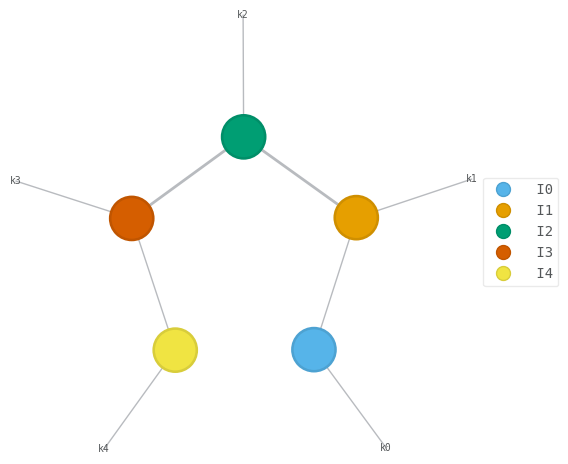

In [31]:
obj._interface._circuitMPS.psi.draw(
    color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True
)

In [32]:
# obj.compute_derivatives(tape)

In [33]:
# obj._interface.state_to_array()

In [34]:
obj._interface._circuitMPS._psi

MatrixProductState(tensors=5, indices=10, L=5, max_bond=4)

# Playing with `quimb`

In [35]:
wires = Wires(range(7))

init_state = qtn.MPS_computational_state(
    "0" * len(wires), tags=[str(l) for l in wires.labels]
)

qc = qtn.CircuitMPS(psi0=init_state)

op = qml.CNOT(wires=[0, 1])

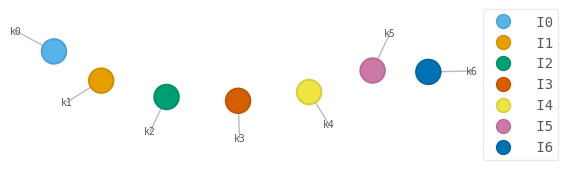

In [36]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)

In [37]:
init_state.gate_

functools.partial(<bound method gate_TN_1D of MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)>, inplace=True)

In [38]:
qc.amplitude("0111111")

0j

In [39]:
init_state

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [40]:
qc.ket_site_ind

<function str.format>

In [41]:
qc.__dict__

{'_psi': MatrixProductState(tensors=7, indices=7, L=7, max_bond=2),
 'N': 7,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': 0,
 '_storage': {('psi_simplified',
   'ADCRS',
   1e-12): MatrixProductState(tensors=7, indices=7, L=7, max_bond=2)},
 '_sampled_conditionals': {},
 '_marginal_storage_size': 0}

In [42]:
qc.gates

[]

In [43]:
gate = qtn.circuit.parse_to_gate(op.matrix(), tuple(op.wires))

In [44]:
gate

<Gate(label=RAW139717894870384, params=raw, qubits=((0, 1),))>

In [45]:
qtn.MPS_computational_state("0" * len(wires), tags=[str(l) for l in wires.labels])

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [46]:
qtn.MPS_zero_state(bond_dim=6, L=9)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

In [47]:
qtn.MPS_rand_state(L=9, bond_dim=6)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

In [56]:
ops = {
    "Identity": qml.Identity(wires=[0]),
    "BlockEncode": qml.BlockEncode([[0.1, 0.2], [0.3, 0.4]], wires=[0, 1]),
    "CNOT": qml.CNOT(wires=[0, 1]),
    "CRX": qml.CRX(0, wires=[0, 1]),
    "CRY": qml.CRY(0, wires=[0, 1]),
    "CRZ": qml.CRZ(0, wires=[0, 1]),
    "CRot": qml.CRot(0, 0, 0, wires=[0, 1]),
    "CSWAP": qml.CSWAP(wires=[0, 1, 2]),
    "CZ": qml.CZ(wires=[0, 1]),
    "CCZ": qml.CCZ(wires=[0, 1, 2]),
    "CY": qml.CY(wires=[0, 1]),
    "CH": qml.CH(wires=[0, 1]),
    "DiagonalQubitUnitary": qml.DiagonalQubitUnitary(np.array([1, 1]), wires=[0]),
    "Hadamard": qml.Hadamard(wires=[0]),
    "MultiRZ": qml.MultiRZ(0, wires=[0]),
    "PauliX": qml.X(0),
    "PauliY": qml.Y(0),
    "PauliZ": qml.Z(0),
    "X": qml.X([0]),
    "Y": qml.Y([0]),
    "Z": qml.Z([0]),
    "PhaseShift": qml.PhaseShift(0, wires=[0]),
    "PCPhase": qml.PCPhase(0, 1, wires=[0, 1]),
    "ControlledPhaseShift": qml.ControlledPhaseShift(0, wires=[0, 1]),
    "CPhaseShift00": qml.CPhaseShift00(0, wires=[0, 1]),
    "CPhaseShift01": qml.CPhaseShift01(0, wires=[0, 1]),
    "CPhaseShift10": qml.CPhaseShift10(0, wires=[0, 1]),
    "QubitUnitary": qml.QubitUnitary(np.eye(2), wires=[0]),
    "SpecialUnitary": qml.SpecialUnitary(np.array([0.2, -0.1, 2.3]), wires=1),
    "ControlledQubitUnitary": qml.ControlledQubitUnitary(
        np.eye(2), control_wires=[1], wires=[0]
    ),
    "MultiControlledX": qml.MultiControlledX(wires=[1, 2, 0]),
    "IntegerComparator": qml.IntegerComparator(1, geq=True, wires=[0, 1, 2]),
    "RX": qml.RX(0, wires=[0]),
    "RY": qml.RY(0, wires=[0]),
    "RZ": qml.RZ(0, wires=[0]),
    "Rot": qml.Rot(0, 0, 0, wires=[0]),
    "S": qml.S(wires=[0]),
    "Adjoint(S)": qml.adjoint(qml.S(wires=[0])),
    "SWAP": qml.SWAP(wires=[0, 1]),
    "ISWAP": qml.ISWAP(wires=[0, 1]),
    "PSWAP": qml.PSWAP(0, wires=[0, 1]),
    "ECR": qml.ECR(wires=[0, 1]),
    "Adjoint(ISWAP)": qml.adjoint(qml.ISWAP(wires=[0, 1])),
    "T": qml.T(wires=[0]),
    "Adjoint(T)": qml.adjoint(qml.T(wires=[0])),
    "SX": qml.SX(wires=[0]),
    "Adjoint(SX)": qml.adjoint(qml.SX(wires=[0])),
    "Toffoli": qml.Toffoli(wires=[0, 1, 2]),
    "QFT": qml.templates.QFT(wires=[0, 1, 2]),
    "IsingXX": qml.IsingXX(0, wires=[0, 1]),
    "IsingYY": qml.IsingYY(0, wires=[0, 1]),
    "IsingZZ": qml.IsingZZ(0, wires=[0, 1]),
    "IsingXY": qml.IsingXY(0, wires=[0, 1]),
    "SingleExcitation": qml.SingleExcitation(0, wires=[0, 1]),
    "SingleExcitationPlus": qml.SingleExcitationPlus(0, wires=[0, 1]),
    "SingleExcitationMinus": qml.SingleExcitationMinus(0, wires=[0, 1]),
    "DoubleExcitation": qml.DoubleExcitation(0, wires=[0, 1, 2, 3]),
    "DoubleExcitationPlus": qml.DoubleExcitationPlus(0, wires=[0, 1, 2, 3]),
    "DoubleExcitationMinus": qml.DoubleExcitationMinus(0, wires=[0, 1, 2, 3]),
    "QubitCarry": qml.QubitCarry(wires=[0, 1, 2, 3]),
    "QubitSum": qml.QubitSum(wires=[0, 1, 2]),
    "PauliRot": qml.PauliRot(0, "XXYY", wires=[0, 1, 2, 3]),
    "U1": qml.U1(0, wires=0),
    "U2": qml.U2(0, 0, wires=0),
    "U3": qml.U3(0, 0, 0, wires=0),
    "SISWAP": qml.SISWAP(wires=[0, 1]),
    "Adjoint(SISWAP)": qml.adjoint(qml.SISWAP(wires=[0, 1])),
    "OrbitalRotation": qml.OrbitalRotation(0, wires=[0, 1, 2, 3]),
    "FermionicSWAP": qml.FermionicSWAP(0, wires=[0, 1]),
    "GlobalPhase": qml.GlobalPhase(0.123, wires=[0, 1]),
}

all_ops = ops.keys()

In [62]:
for op in all_ops:
    if not ops[op].has_matrix:
        print(ops[op])
        assert False
    mat = ops[op].matrix()   
    name = ops[op].name 
    if mat.dtype == int:
        print(mat)
        print(name)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
CNOT
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]]
CSWAP
[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]
CZ
[[ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]
CCZ
[[1 0]
 [0 1]]
DiagonalQubitUnitary
[[0 1]
 [1 0]]
PauliX
[[ 1  0]
 [ 0 -1]]
PauliZ
[[0 1]
 [1 0]]
PauliX
[[ 1  0]
 [ 0 -1]]
PauliZ
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]
SWAP
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]
Toffoli
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0